Unlike traditional RAG techniques, which passively retrieve context and generate responses, **agentic RAG** involves active decision-making and multi-step reasoning by the chatbot. Instead of just fetching data, the chatbot makes decisions, dynamically interacts with various data sources, and adapts based on context, giving it a much more dynamic and intelligent approach.

In this tutorial, we’ll develop a fully functional chatbot using Qdrant, [CAMEL-AI](https://www.camel-ai.org/), and [OpenAI](https://openai.com/).

Let’s get started!


| Step | Description                                                                                                       |
|------|-------------------------------------------------------------------------------------------------------------------|
| **1. Environment Setup**                | Install required libraries (`camel-ai`, `qdrant-client`, `discord.py`) and set up the Python environment.  |
| **2. Set Up the OpenAI Embedding Instance** | Create an OpenAI account, generate an API key, and configure the embedding model.                           |
| **3. Configure the Qdrant Client** | Sign up for Qdrant Cloud, create a cluster, configure `QdrantStorage`, and set up the API connection.    |
| **4. Scrape and Process Data**          | Use `VectorRetriever` to scrape Qdrant documentation, chunk text, and store embeddings in Qdrant.          |
| **5. Set Up the CAMEL-AI ChatAgent**    | Instantiate a CAMEL-AI `ChatAgent` with OpenAI models for multi-step reasoning and context-aware responses. |
| **6. Create and Configure the Discord Bot** | Register a new bot in the Discord Developer Portal, invite it to a server, and enable permissions.      |
| **7. Build the Discord Bot**            | Integrate Discord.py with CAMEL-AI and Qdrant to retrieve context and generate intelligent responses.      |
| **8. Test the Bot**                     | Run the bot in a live Discord server and verify that it provides relevant, context-rich answers.          |

The workflow starts by **scraping, chunking, and upserting** content from URLs using the `vector_retriever.process()` method, which generates embeddings with the **OpenAI embedding instance**. These embeddings, along with their metadata, are then indexed and stored in **Qdrant** via the `QdrantStorage` class.

When a user sends a query through the **Discord bot**, it is processed by `vector_retriever.query()`, which first embeds the query using **OpenAI Embeddings** and then retrieves the most relevant matches from Qdrant via `QdrantStorage`. The retrieved context (e.g., relevant documentation snippets) is then passed to an **OpenAI-powered Qdrant Agent** under **CAMEL-AI**, which generates a final, context-aware response.

The Qdrant Agent processes the retrieved vectors using the `GPT_4O_MINI` language model, producing a response that is contextually relevant to the user's query. This response is then sent back to the user through the **Discord bot**, completing the flow.

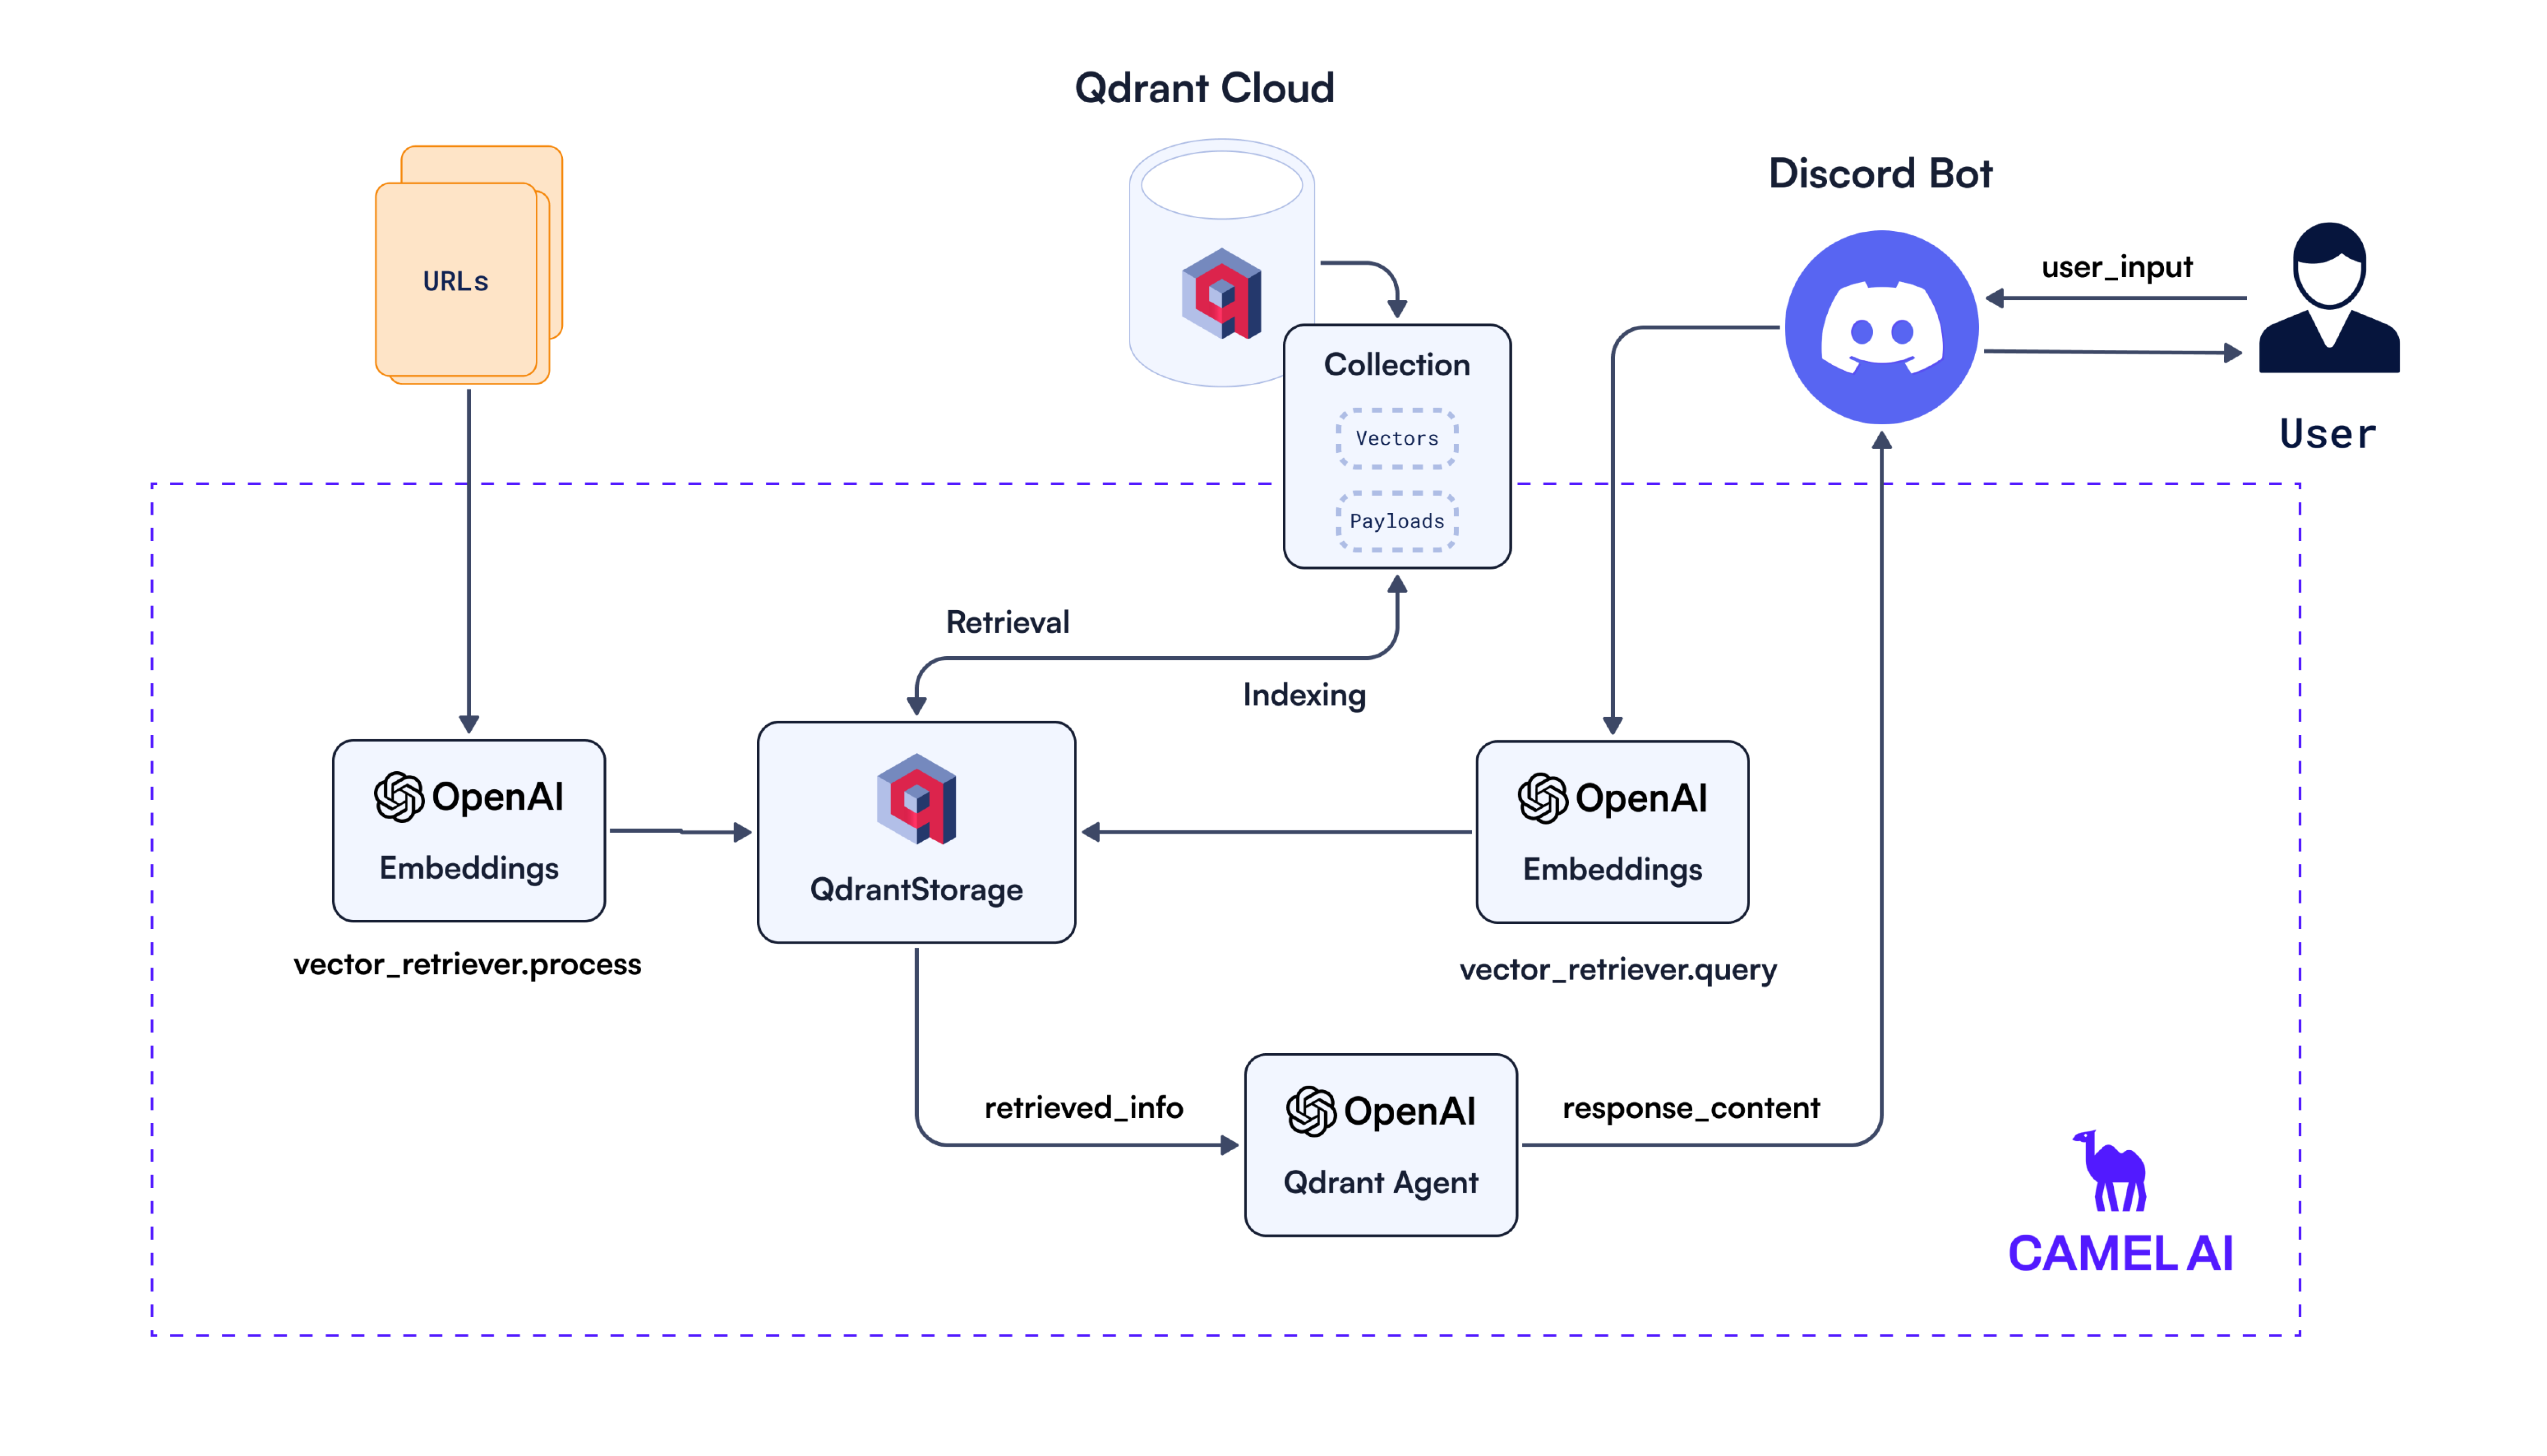

## **Step 1: Environment Setup**
To build our chatbot, we’ll install CAMEL-AI, which includes all necessary dependencies:

In [ ]:
!pip install camel-ai[all]==0.2.17

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 37.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of firecrawl-py to determine which version is compatible with o

## Step 2. Set Up the OpenAI Embedding Instance
**Create an OpenAI Account**: Go to [OpenAI](https://platform.openai.com/signup) and sign up for an account if you don’t already have one.

2. **Generate an API Key**:

    - After logging in, click on your profile icon in the top-right corner and select **API keys**.

    - Click **Create new secret key**.

    - Copy the generated API key and store it securely. You won’t be able to see it again.

In [ ]:
import os
from getpass import getpass

openai_api_key = getpass('Enter your API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

Enter your API key: ··········


In [ ]:
import openai
import os
from dotenv import load_dotenv

load_dotenv()

openai_client = openai.Client(
    api_key=os.getenv("OPENAI_API_KEY")
)

To set up the embedding instance, we will use text embedding 3 large:

In [ ]:
from camel.embeddings import OpenAIEmbedding
from camel.types import EmbeddingModelType

embedding_instance = OpenAIEmbedding(model_type=EmbeddingModelType.TEXT_EMBEDDING_3_LARGE)

## Step 3. Configure the Qdrant client
For this tutorial, we will be using the **Qdrant Cloud Free Tier**. Here's how to set it up:

1. **Create an Account**:  Sign up for a Qdrant Cloud account at [Qdrant Cloud](https://cloud.qdrant.io).

2. **Create a Cluster**:  
   - Navigate to the **Overview** section.  
   - Follow the onboarding instructions under **Create First Cluster** to set up your cluster.  
   - When you create the cluster, you will receive an **API Key**. Copy and securely store it, as you will need it later.  


In [ ]:
import os
from getpass import getpass
from qdrant_client import QdrantClient

# Prompt user to enter Qdrant Cloud API key
qdrant_api_key = getpass('Enter your Qdrant Cloud API key: ')
os.environ["QDRANT_CLOUD_API_KEY"] = qdrant_api_key

# Set Qdrant Cloud URL
qdrant_cloud_url = input('Enter your Qdrant Cloud URL: ')
os.environ["QDRANT_CLOUD_URL"] = qdrant_cloud_url

# Define collection name
collection_name = "discord-bot"

# Initialize Qdrant client
client = QdrantClient(
    url=os.getenv("QDRANT_CLOUD_URL"),
    api_key=os.getenv("QDRANT_CLOUD_API_KEY")
)

Enter your Qdrant Cloud API key: ··········
Enter your Qdrant Cloud URL: https://a80d6200-a5b9-4a54-9253-10a436e56601.europe-west3-0.gcp.cloud.qdrant.io


### Configure the QdrantStorage

The `QdrantStorage` will deal with connecting with the Qdrant Client for all necessary operations to your collection.



In [ ]:
from camel.storages import QdrantStorage

# Define collection name
collection_name = "qdrant-agent"

storage_instance = QdrantStorage(
    vector_dim=embedding_instance.get_output_dim(),
    url_and_api_key=(
        qdrant_cloud_url,
        qdrant_api_key,
    ),
    collection_name=collection_name,
)

## **Step 4: Scrape and Process Data**
We'll use CamelAI `VectorRetriever` library to help us to It processes content from a file or URL, divides it into chunks, and stores the embeddings in the specified Qdrant collection.


In [ ]:
from camel.retrievers import VectorRetriever
from tqdm import tqdm

vector_retriever = VectorRetriever(embedding_model=embedding_instance,
                                   storage=storage_instance)

qdrant_urls = [
    "https://qdrant.tech/articles/gridstore-key-value-storage/#the-grand-solution-lazy-updates",
    # Add more URLs as needed
]

for qdrant_url in tqdm(qdrant_urls, desc="Processing URLs"):
    vector_retriever.process(content=qdrant_url)


Processing URLs: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]


## **Step 5: Step 5: Setup the CAMEL-AI ChatAgent Instance**

Define the OpenAI model and create a CAMEL-AI ChatAgent instance.


### Set Up the Agent

Define the OpenAI model and create a CAMEL-AI compatible OpenAI instance.

In [ ]:
from camel.configs import ChatGPTConfig
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.agents import ChatAgent

# Create a ChatGPT configuration
config = ChatGPTConfig(temperature=0.2).as_dict()

# Create an OpenAI model using the configuration
openai_model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O_MINI,
    model_config_dict=config,
)

assistant_sys_msg = """You are a highly knowledgeable technical assistant specializing in providing accurate,
concise, and well-structured answers based on the retrieved documentation.
Your primary goal is to help users understand and navigate the documentation
efficiently. If the retrieved content does not contain the answer, state that
explicitly and avoid making assumptions. Provide step-by-step instructions, code examples,
or links when applicable. Reference the specific section of the retrieved documentation when possible.
Do not generate information beyond the retrieved knowledge. """

qdrant_agent = ChatAgent(system_message=assistant_sys_msg, model=openai_model)

## **Step 6: Create and Configure the Discord Bot**

Now let's bring the bot to life! It will serve as the interface through which users can interact with the agentic RAG system you’ve built.

### Create a New Discord Bot

1. Go to the [Discord Developer Portal](https://discord.com/developers/applications) and log in with your Discord account.

2. Click on the **New Application** button.

3. Give your application a name and click **Create**.

4. Navigate to the **Bot** tab on the left sidebar and click **Add Bot**.

5. Once the bot is created, click **Reset Token** under the **Token** section to generate a new bot token. Copy this token securely as you will need it later.

### Invite the Bot to Your Server

1. Go to the **OAuth2** tab and then to the **URL Generator** section.

2. Under **Scopes**, select **bot**.

3. Under **Bot Permissions**, select the necessary permissions:

   - Send Messages

   - Read Message History

4. Copy the generated URL and paste it into your browser.

5. Select the server where you want to invite the bot and click **Authorize**.

### Grant the Bot Permissions

1. Go back to the **Bot** tab.

2. Enable the following under **Privileged Gateway Intents**:

   - Server Members Intent

   -  Message Content Intent

Now, the bot is ready to be integrated with your code.

## **Step 8: Build the Discord Bot**

In [ ]:
import os
from getpass import getpass

discord_bot_token = getpass('Enter your Token: ')
os.environ["DISCORD_BOT_TOKEN"] = discord_bot_token

Enter your Token: ··········


We'll use `discord.py` to create a simple Discord bot that interacts with users and retrieves context from Qdrant before responding.

This code cell sets up a simple Discord bot using the `DiscordApp` class from the `camel.bots` library. The bot listens for messages in any channel it has access to and provides a response based on the input message.

In [ ]:
from camel.bots import DiscordApp
import nest_asyncio
import discord

nest_asyncio.apply()
discord_q_bot = DiscordApp(token=os.getenv("DISCORD_BOT_TOKEN"))

@discord_q_bot.client.event # triggers when a message is sent in the channel
async def on_message(message: discord.Message):
    if message.author == discord_q_bot.client.user:
        return

    if message.type != discord.MessageType.default:
        return

    if message.author.bot:
        return
    user_input = message.content

    retrieved_info = vector_retriever.query(
        query=user_input, top_k=30, similarity_threshold=0.6
    )

    user_msg = str(retrieved_info)
    assistant_response = qdrant_agent.step(user_msg)
    response_content = assistant_response.msgs[0].content

    if len(response_content) > 2000: # discord message length limit
        for chunk in [response_content[i:i+2000] for i in range(0, len(response_content), 2000)]:
            await message.channel.send(chunk)
    else:
        await message.channel.send(response_content)

discord_q_bot.run()

2025-02-06 12:58:50 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token
2025-02-06 12:58:51 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 73563c021d4b3fd7a5885f4c4238683c).
INFO:discord.gateway:Shard ID None has connected to Gateway (Session ID: 73563c021d4b3fd7a5885f4c4238683c).
2025-02-06 14:12:48 INFO     discord.gateway Shard ID None has successfully RESUMED session 73563c021d4b3fd7a5885f4c4238683c.
INFO:discord.gateway:Shard ID None has successfully RESUMED session 73563c021d4b3fd7a5885f4c4238683c.
2025-02-06 14:36:44 INFO     discord.gateway Shard ID None has successfully RESUMED session 73563c021d4b3fd7a5885f4c4238683c.
INFO:discord.gateway:Shard ID None has successfully RESUMED session 73563c021d4b3fd7a5885f4c4238683c.
2025-02-06 14:43:30 INFO     discord.gateway Shard ID None has successfully RESUMED session 73563c021d4b3fd7a5885f4c4238683c.
INFO:discord.gateway:Shard ID None has successfully RE